In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import statistics
import kmax as kx
import utility as util
from hierarchy import *

# Erdos-Renyi Simulations

### TODO
[ ] Simulate $\frac{\sum{T_i}}{n} \to \frac{EX}{EN}$

In [2]:
def my_draw(tree, draw_path=True):
    #layout = hierarchyc_pos(tree, 0)
    layout = nx.spring_layout(tree)
    # nx.draw_networkx_nodes(tree, pos=layout, node_size=4)
    nx.draw_networkx_labels(tree, pos=layout, font_size=8, font_color="tab:blue")
    
    #if draw_path:
    #    path_cover,_=util.path_cover(tree)
    #    nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=path_cover, edge_color="tab:red", arrows=True)
    #    
    #    other_edges = [(u,v) for u,v in rooted_tree.edges() if (u,v) not in path_cover and (v,u) not in path_cover]
    #    nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=other_edges)
    #else:
    nx.draw_networkx_edges(tree, pos=layout)

# Generate Tree

In [3]:
# Constants
n = 20
lam = 0.7

tree = nx.erdos_renyi_graph(n, lam/n)
for u,v in tree.edges():
    tree[u][v]['weight'] = 1

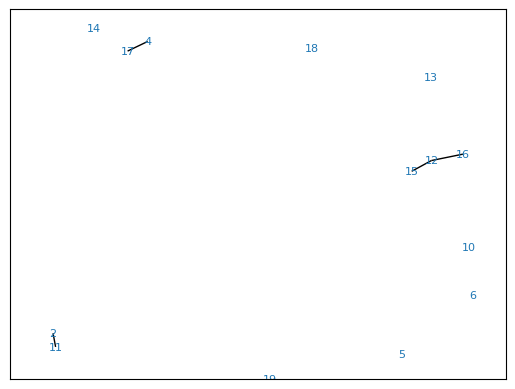

In [4]:
my_draw(tree)

# Simulation

In [5]:
def expectation_X_sample(sample_tree): 
    X = 0
    for nodes in nx.connected_components(sample_tree):
        subgraph = sample_tree.subgraph(nodes)
        path, _, Xi = util.path_cover(subgraph, list(nodes)[0])
        X += Xi
        
    return X / nx.number_connected_components(sample_tree)

In [6]:
def expectation_X(n, lam, num_samples=100):
    Xs = 0
    for _ in range(num_samples):
        # Generate Erdos-Renyi graph (G(n,lam/n))
        sample_tree = nx.erdos_renyi_graph(n, lam/n)
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        # Calculate EX for current sample
        Xs += expectation_X_sample(sample_tree)
    return Xs / num_samples

In [7]:
expectation_X(100, 0.7)

0.49633524702963927

In [8]:
ns = list(range(1,100))
values = [expectation_X(n,0.7) for n in ns]

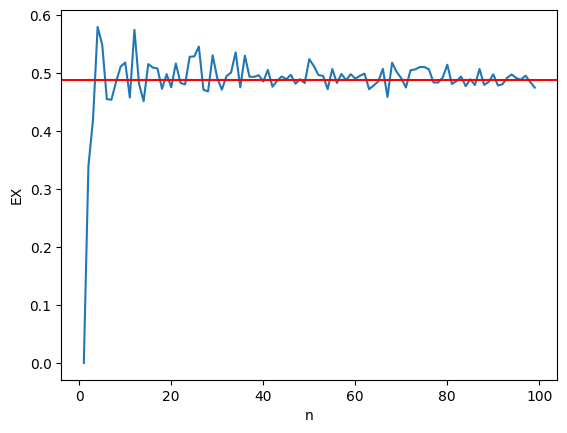

In [9]:
plt.plot(ns, values)
plt.xlabel("n")
plt.ylabel("EX")
plt.axhline(y=statistics.mean(values), color='red')